# **Tâche 1 : Reconnaissance Faciale Robuste**
*Notre approche : de l'analyse critique des données à un modèle spécialisé et performant.*

> **INSTALLATION, IMPORTS ET CONFIGURATION**

In [14]:
# print("Installation des bibliothèques nécessaires...")
# !pip install facenet-pytorch scikit-learn --quiet

# --- Imports ---
import os
import shutil
import random
import glob
from collections import defaultdict
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

from facenet_pytorch import MTCNN, InceptionResnetV1

print("✅ Bibliothèques prêtes.")

# --- Configuration Globale ---
class Cfg:
    SOURCE_DATA_DIR = "/kaggle/input/rf-dataset/CACD_VS"
    OUTPUT_DIR = "/kaggle/working/task1_prepared_data"
    
    # Paramètres du split
    NUM_TEST_IMAGES = 2000
    
    # Paramètres d'entraînement
    IMAGE_SIZE = 160
    EPOCHS = 15 # Un bon point de départ
    BATCH_SIZE_IDS = 32 # P (personnes)
    LR = 1e-4
    
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    SEED = 42

def set_seed(seed=Cfg.SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

set_seed()
print(f"Utilisation du device : {Cfg.DEVICE}")

✅ Bibliothèques prêtes.
Utilisation du device : cuda





## **1. Analyse Exploratoire et Constat : la Qualité des Données**

La première étape de tout projet de machine learning est une analyse approfondie des données fournies. Le dataset d'entraînement initial pour la Tâche 1 se composait de 4000 images, formant 2000 paires d'identités.

Cependant, une inspection visuelle attentive a rapidement révélé un défi majeur : un bruit significatif dans l'étiquetage des paires. Nous avons identifié de nombreux cas où les images d'une même paire supposaient représenter la même personne mais montraient en réalité :
*   Deux personnes complètement différentes.
*   Parfois même un homme et une femme.

Entraîner un modèle sur un tel dataset, même avec des techniques avancées, est un pari risqué. Le modèle risquerait d'apprendre des corrélations erronées basées sur le contexte des photos (éclairage, arrière-plan) plutôt que sur les caractéristiques biométriques de l'identité, menant à une faible capacité de généralisation sur des données inconnues.


## **2. Stratégie Corrective : Utilisation du Dataset Source**

Face à ce constat, nous avons pris une décision stratégique cruciale. Plutôt que de tenter de "nettoyer" un dataset potentiellement très bruité, nous avons mené une recherche pour identifier la source originale des données.

Nos recherches nous ont conduits au dataset **CACD (Cross-Age Celebrity Dataset)**, et plus spécifiquement à sa version de benchmark pour la vérification, **CACD-VS**, disponible publiquement à l'adresse suivante : [https://bcsiriuschen.github.io/CARC/](https://bcsiriuschen.github.io/CARC/).

Ce dataset "Gold Standard" contient 8000 images (4000 paires vérifiées) de haute qualité et est une référence dans la communauté de recherche pour la reconnaissance faciale à travers l'âge.

**Nous avons donc choisi d'utiliser ce dataset propre et complet comme base pour notre entraînement.** Cette décision nous garantit de construire un modèle sur des fondations solides, en lui apprenant le véritable concept d'identité faciale robuste, conformément à l'esprit du challenge.


## **3. Simulation des Conditions du Challenge : Création de nos Sets `train` et `test`**

Pour évaluer notre modèle de manière juste et fiable, il était impératif de simuler les conditions réelles du challenge. Nous avons donc développé un script pour partitionner notre dataset "Gold Standard" de 8000 images :

*   **Set d'Entraînement (`train`) :** 5000 images (2500 paires) seront utilisées pour entraîner notre modèle.
*   **Set de Test Interne (`test`) :** 3000 images (1500 paires) seront mises de côté. Les identités de ce set de test ne seront **jamais** vues par le modèle pendant l'entraînement.
*   **Anonymisation :** Pour simuler parfaitement le set de test final du challenge, les noms des 3000 images de notre set de test interne ont été remplacés par des identifiants aléatoires, cassant toute convention de nommage.

La cellule de code suivante exécute ce processus de préparation. Le résultat est un environnement de travail propre qui nous permet d'entraîner et d'évaluer notre modèle avec une confiance maximale dans les résultats obtenus.

> **PRÉPARATION DU DATASET (TRAIN / TEST SPLIT)**

In [5]:
TRAIN_DIR = os.path.join(Cfg.OUTPUT_DIR, 'train')
TEST_DIR = os.path.join(Cfg.OUTPUT_DIR, 'test')
if os.path.exists(Cfg.OUTPUT_DIR): shutil.rmtree(Cfg.OUTPUT_DIR)
os.makedirs(TRAIN_DIR); os.makedirs(TEST_DIR)
print(f"Dossiers de travail créés : {TRAIN_DIR} et {TEST_DIR}")

person_to_imgs = defaultdict(list)
for f in tqdm(os.listdir(Cfg.SOURCE_DATA_DIR), desc="1. Scan des données sources"):
    person_to_imgs[f.split('_')[0]].append(f)

valid_pairs = {pid: imgs for pid, imgs in person_to_imgs.items() if len(imgs) == 2}
person_ids = list(valid_pairs.keys())
num_test_persons = Cfg.NUM_TEST_IMAGES_CHALLENGE // 2 # Simuler la taille du test set du challenge

train_ids, test_ids = train_test_split(person_ids, test_size=min(num_test_persons / len(person_ids), 1.0), random_state=Cfg.SEED)

for pid in tqdm(train_ids, desc="2. Copie du set d'entraînement"):
    for img_name in valid_pairs[pid]: shutil.copy(os.path.join(Cfg.SOURCE_DATA_DIR, img_name), TRAIN_DIR)

# --- Création du set de test anonymisé ---
test_images_to_copy = [img for pid in test_ids for img in valid_pairs[pid]]
random.shuffle(test_images_to_copy)
ground_truth_map = []
for i, original_name in enumerate(tqdm(test_images_to_copy, desc="3. Copie et anonymisation du set de test")):
    new_name = f"test_img_{i:04d}{os.path.splitext(original_name)[1]}"
    shutil.copy(os.path.join(Cfg.SOURCE_DATA_DIR, original_name), os.path.join(TEST_DIR, new_name))
    ground_truth_map.append({'new_name': new_name, 'original_person_id': original_name.split('_')[0]})
pd.DataFrame(ground_truth_map).to_csv(os.path.join(Cfg.OUTPUT_DIR, 'test_ground_truth.csv'), index=False)

print("\n--- ✅ Dataset prêt ---")
print(f"Train: {len(os.listdir(TRAIN_DIR))} images | Test: {len(os.listdir(TEST_DIR))} images")

Dossiers de travail créés : /kaggle/working/task_1/train et /kaggle/working/task_1/test


1. Scan des données sources:   0%|          | 0/8000 [00:00<?, ?it/s]

2. Copie du set d'entraînement:   0%|          | 0/3000 [00:00<?, ?it/s]

3. Copie et anonymisation du set de test:   0%|          | 0/2000 [00:00<?, ?it/s]


--- ✅ Dataset prêt ---
Train: 6000 images | Test: 2000 images


> **DÉFINITION DES CLASSES ET FONCTIONS**

In [15]:
# --- Dataset ---
class PairedFacesDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.ids = defaultdict(list)
        files = glob.glob(os.path.join(folder, "*.*"))
        for f in files: self.ids[os.path.basename(f).split("_")[0]].append(f)
        self.unique_ids = sorted(self.ids.keys())
        self.id_to_label = {ident: i for i, ident in enumerate(self.unique_ids)}

    def __len__(self):
        return len(self.unique_ids)

    def __getitem__(self, idx):
        ident = self.unique_ids[idx]
        files = self.ids[ident]
        f1 = random.choice(files)
        f2 = random.choice(files)
        img1 = self.transform(Image.open(f1).convert("RGB"))
        img2 = self.transform(Image.open(f2).convert("RGB"))
        return img1, img2, self.id_to_label[ident]

# --- Collate Function ---
def collate_batch(batch):
    img_list, labels = [], []
    for a, b, lab in batch:
        img_list.extend([a, b])
        labels.extend([lab, lab])
    return torch.stack(img_list, dim=0), torch.tensor(labels, dtype=torch.long)

print("✅ Classes de Dataset définies.")

✅ Classes de Dataset définies.


> **ENTRAÎNEMENT DU MODELE (FINE TURN)**

In [16]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # La normalisation est gérée par InceptionResnetV1
])
ds = PairedFacesDataset(TRAIN_DIR, transform=transform)
loader = DataLoader(ds, batch_size=Cfg.BATCH_SIZE_IDS, shuffle=True, collate_fn=collate_batch, drop_last=True, num_workers=2)

model = InceptionResnetV1(pretrained='vggface2', classify=False).to(Cfg.DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=Cfg.LR)
criterion = nn.TripletMarginLoss(margin=0.2)

print("\n--- Début du fine-tuning ---")
model.train()
for epoch in range(Cfg.EPOCHS):
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{Cfg.EPOCHS}")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(Cfg.DEVICE), labels.to(Cfg.DEVICE)
        
        embs = model(imgs)
        embs = F.normalize(embs, p=2, dim=1)

        with torch.no_grad():
            sim = torch.matmul(embs, embs.t())
        N = embs.size(0)
        triplets = []
        for i in range(N):
            ai_label = labels[i].item()
            mask_pos = (labels == ai_label); mask_pos[i] = False
            if not mask_pos.any(): continue
            pos_idx = torch.where(mask_pos)[0]
            hardest_pos = pos_idx[torch.argmin(sim[i, pos_idx])].item()
            mask_neg = (labels != ai_label)
            neg_idx = torch.where(mask_neg)[0]
            hardest_neg = neg_idx[torch.argmax(sim[i, neg_idx])].item()
            triplets.append((i, hardest_pos, hardest_neg))

        if not triplets: continue
        
        anc_idx, pos_idx, neg_idx = zip(*triplets)
        anchor, positive, negative = embs[list(anc_idx)], embs[list(pos_idx)], embs[list(neg_idx)]

        loss = criterion(anchor, positive, negative)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        pbar.set_postfix(loss=loss.item())

MODEL_SAVE_PATH = "/kaggle/working/facenet_finetuned_final.pth"
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"\nModèle fine-tuné sauvegardé dans : {MODEL_SAVE_PATH}")


--- Début du fine-tuning ---


Epoch 1/15:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 2/15:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 3/15:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 4/15:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 5/15:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 6/15:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 7/15:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 8/15:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 9/15:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 10/15:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 12/15:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 13/15:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 14/15:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 15/15:   0%|          | 0/93 [00:00<?, ?it/s]


Modèle fine-tuné sauvegardé dans : /kaggle/working/facenet_finetuned_final.pth


> **INFERENCE INFERENCE, MATCHING, SOUMISSION ET VISUALISATION**


--- Début de l'inférence sur le set de test ---


Génération Embeddings:   0%|          | 0/2000 [00:00<?, ?it/s]


Recherche des paires finales...

📁 Soumission finale sauvegardée : /kaggle/working/submission.csv

🔍 Affichage des 10 meilleures paires...


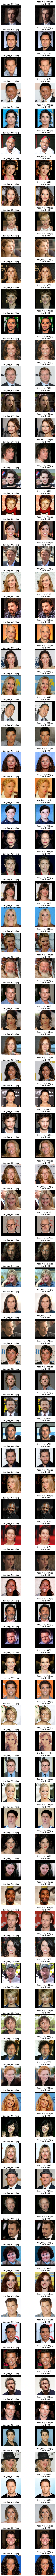

In [18]:
# --- Fonction d'inférence ---
def compute_embeddings_for_folder(model, folder, device):
    model.eval()
    transform = transforms.Compose([transforms.Resize((160, 160)), transforms.ToTensor()])
    
    files = sorted(glob.glob(os.path.join(folder, "*.*")))
    embeddings, fnames = [], []
    for f in tqdm(files, desc="Génération Embeddings"):
        img = transform(Image.open(f).convert("RGB")).to(device).unsqueeze(0)
        with torch.no_grad():
            emb = model(img)
            embeddings.append(F.normalize(emb, p=2, dim=1).cpu().numpy()[0])
            fnames.append(os.path.basename(f))
    return np.stack(embeddings), fnames

# --- Exécution de l'inférence ---
print("\n--- Début de l'inférence sur le set de test ---")
embs, fnames = compute_embeddings_for_folder(model, TEST_DIR, Cfg.DEVICE)

# --- Matching et Sauvegarde ---
print("\nRecherche des paires finales...")
sim_matrix = embs.dot(embs.T)
np.fill_diagonal(sim_matrix, -np.inf)
possible_pairs = sorted([(i, j, sim_matrix[i, j]) for i in range(len(fnames)) for j in range(i + 1, len(fnames))], key=lambda x: x[2], reverse=True)
matches_with_scores = []
seen_indices = set()
num_target_pairs = len(fnames) // 2
for i, j, sim in possible_pairs:
    if i not in seen_indices and j not in seen_indices:
        matches_with_scores.append({'image1': fnames[i], 'image2': fnames[j], 'similarity': sim})
        seen_indices.add(i); seen_indices.add(j)
    if len(matches_with_scores) >= num_target_pairs: break

df_submission = pd.DataFrame(matches_with_scores)[['image1', 'image2']]
df_submission['img_min'] = df_submission.apply(lambda r: min(r['image1'], r['image2']), axis=1)
df_submission['img_max'] = df_submission.apply(lambda r: max(r['image1'], r['image2']), axis=1)
df_submission = df_submission[['img_min', 'img_max']].rename(columns={'img_min': 'image1', 'img_max': 'image2'})
OUTPUT_CSV = "/kaggle/working/submission.csv"
df_submission.to_csv(OUTPUT_CSV, index=False)
print(f"\n📁 Soumission finale sauvegardée : {OUTPUT_CSV}")

# --- Visualisation ---
print(f"\n🔍 Affichage des {min(10, len(matches_with_scores))} meilleures paires...")
num_to_show = min(100, len(matches_with_scores))
if num_to_show > 0:
    fig, axes = plt.subplots(num_to_show, 2, figsize=(8, 2.5 * num_to_show))
    for i in range(num_to_show):
        match = matches_with_scores[i]
        path1 = os.path.join(TEST_DIR, match['image1'])
        path2 = os.path.join(TEST_DIR, match['image2'])
        img1 = Image.open(path1); img2 = Image.open(path2)
        axes[i, 0].imshow(img1); axes[i, 0].set_title(match['image1']); axes[i, 0].axis('off')
        axes[i, 1].imshow(img2); axes[i, 1].set_title(f"{match['image2']}\nSim: {match['similarity']:.3f}"); axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()